In [1]:
!pip install pyspark
!pip install langdetect translate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1dd8a437c4e52cef6f82c20ffadc9d47dbe212cdbc6dbbf34555692c30b066ce
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=01bb81bba7ef82ae5fea1b7b96c09fa5613da95d3f420b6cd092fa1d3862ca1c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, lit

# Créer une session Spark
spark = SparkSession.builder \
    .appName("Lecture de CSV avec Spark") \
    .getOrCreate()

df_wipo = spark.read.csv("/content/big_data_project.wipo_end.csv", header=True)
df_es = spark.read.csv("/content/big_data_project.es.csv", header=True)
df_cana = spark.read.csv("/content/big_data_project.cn.csv", header=True)
df_fpo = spark.read.csv("/content/big_data_project.fpn.csv", header=True)
df_gp = spark.read.csv("/content/big_data_project.gp.csv", header=True)

In [ ]:
df_fpo.show(10, truncate= False)

+------------------------+-------------+----------------------------------------------------------------------------------------------------------------------------------+-------------+------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------+------------------+----------------+-----------+----------------------------------------------+-------------------------------------------------------------------------------+-----------------------+----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, lit


df_wipo = df_wipo.withColumn("Application_Date", to_date("Application_Date", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))
df_es = df_es.withColumn("Date_application", to_date("Date_application", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))
df_cana = df_cana.withColumn("Filled Date", to_date("Filled Date", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))
df_fpo = df_fpo.withColumn("Filing Date", to_date("Filing Date", "MM/dd/yyyy"))
df_gp = df_gp.withColumn("Filing Date", to_date("Filing Date", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))

df_wipo_titles = df_wipo.select("Title", "Abstract", "Inventors", "Application_Date", "Office").withColumn("Source", lit("Wipo"))
df_es_titles = df_es.select("Title", "Patent_abstract", "Inventors", "Date_application", "Country_Name").withColumn("Source", lit("Es"))
df_cana_titles = df_cana.select("Title", "Abstract", "Inventors", "Filled Date", "Country").withColumn("Source", lit("Cana"))
df_fpo_titles = df_fpo.select("Title", "Summary", "Inventors", "Filing Date", "Country").withColumn("Source", lit("Fpo"))
df_gp_titles = df_gp.select("Title", "Abstract", "Inventors", "Filing Date", "Country Name").withColumn("Source", lit("Gp"))

dfs_merged = df_wipo_titles.union(df_es_titles).union(df_cana_titles).union(df_fpo_titles).union(df_gp_titles)

dfs_merged = dfs_merged.withColumnRenamed("Office", "country")

dfs_merged.show(3)



+--------------------+--------------------+--------------------+----------------+-------+------+
|               Title|            Abstract|           Inventors|Application_Date|country|Source|
+--------------------+--------------------+--------------------+----------------+-------+------+
|battery packs for...|a battery system ...|TYERMAN, LANDONCO...|      2022-08-19| Canada|  Wipo|
|electric vehicle ...|an electric vehic...|  ZHAO, DEZHOU DAVID|      2014-10-22| Canada|  Wipo|
|prime mover dispo...|ic engine 2 drive...|CAILLARD BENOITCH...|      1999-04-22| France|  Wipo|
+--------------------+--------------------+--------------------+----------------+-------+------+
only showing top 3 rows



In [4]:
# Compter le nombre de lignes avant la suppression des duplicatas
count_before = dfs_merged.count()

# Supprimer les duplicatas basés sur toutes les colonnes
dfs_merged = dfs_merged.dropDuplicates()

# Compter le nombre de lignes après la suppression des duplicatas
count_after = dfs_merged.count()

# Vérifier s'il y a des duplicatas
if count_before == count_after:
    print("Il n'y a pas de duplicatas.")
else:
    print("Il y a des duplicatas et ils ont été supprimés.")
    print(f"Nombre de lignes avant suppression : {count_before}")
    print(f"Nombre de lignes après suppression : {count_after}")


Il y a des duplicatas et ils ont été supprimés.
Nombre de lignes avant suppression : 5277
Nombre de lignes après suppression : 3572


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Créer la session Spark
spark = SparkSession.builder.appName("IndexingRows").getOrCreate()

# Votre DataFrame initial (remplacez dfs_merged par votre DataFrame)
# dfs_merged = ...

# Convertir le DataFrame en RDD
rdd = dfs_merged.rdd.zipWithIndex()

# Convertir l'RDD avec index en DataFrame
dfs_merged = rdd.map(lambda row: Row(*row[0], row[1])).toDF(dfs_merged.columns + ["row_index"])

# Afficher les premières lignes pour vérifier
dfs_merged.show(5)


+--------------------+--------------------+--------------------+----------------+--------------------+------+---------+
|               Title|            Abstract|           Inventors|Application_Date|             country|Source|row_index|
+--------------------+--------------------+--------------------+----------------+--------------------+------+---------+
|verfahren zur erk...|the invention pro...|BRUST GILLESFLUXA...|      2014-06-25|European Patent O...|  Wipo|        0|
|electric vehicle ...|an electric vehic...|WENGER, URSKOHLER...|      2010-09-16|              Canada|  Wipo|        1|
|batterieeinheit f...|the invention rel...|        JOYE OLIVIER|      2011-04-18|European Patent O...|  Wipo|        2|
|elektrisches zwei...|an electric motor...|KANNO YOSHIHISAKI...|      2009-09-03|European Patent O...|  Wipo|        3|
|on-board device f...|the device has an...|BUFFET DENIS ERNE...|      2012-09-28|              France|  Wipo|        4|
+--------------------+------------------

In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd

# Transformer la DataFrame PySpark en DataFrame Pandas
df_pandas = dfs_merged.toPandas()

# Afficher les premières lignes de la DataFrame Pandas pour vérifier la transformation
df_pandas.head(3)


,Title,Abstract,Inventors,Application_Date,country,Source,row_index
0,verfahren zur erkennung der abschaltung einer ...,the invention proposes a method for detecting ...,BRUST GILLESFLUXA FRÉDÉRICBAGHDASSARIANS VAHÉF...,2014-06-25,European Patent Office,Wipo,0
1,electric vehicle and on-board battery charging...,an electric vehicle and a range extender engin...,"WENGER, URSKOHLER, BEAT RENEJENNI, NANS-RUDOLPH",2010-09-16,Canada,Wipo,1
2,batterieeinheit für ein elektro- oder hybridfa...,the invention relates to a battery unit which ...,JOYE OLIVIER,2011-04-18,European Patent Office,Wipo,2


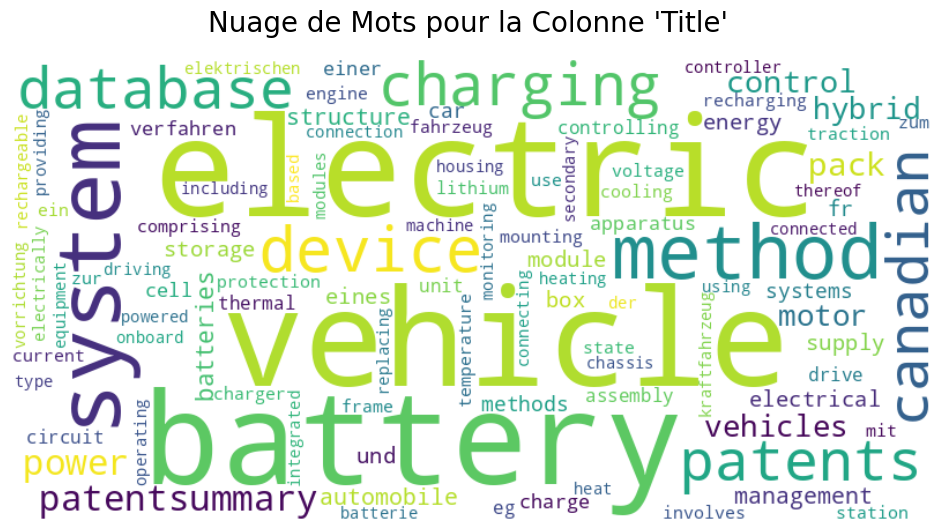

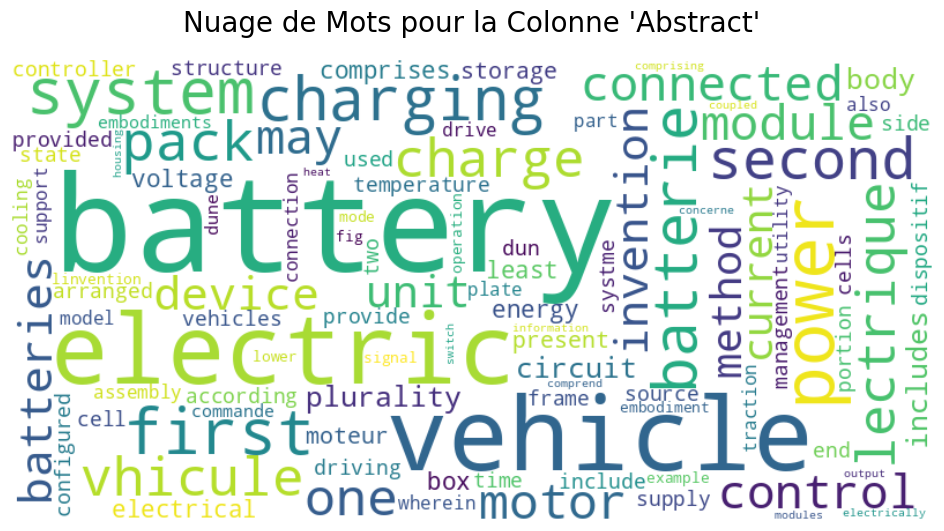

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, isnull, explode
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Initialiser la session Spark
spark = SparkSession.builder \
    .appName("WordCloudExample") \
    .getOrCreate()

# Charger les données dans un DataFrame Spark (supposons dfs_merged est déjà chargé)
# dfs_merged = spark.read.csv("chemin/vers/votre/dataset.csv", header=True)

# Sélectionner les lignes non null pour les colonnes "Title" et "Abstract"
dfs_merged = dfs_merged.filter(col("Title").isNotNull())
dfs_merged = dfs_merged.filter(col("Abstract").isNotNull())

# Nettoyer les titres
dfs_merged = dfs_merged.withColumn("title_cleaned", lower(col("Title")))
dfs_merged = dfs_merged.withColumn("title_cleaned", regexp_replace(col("title_cleaned"), "[^a-zA-Z\\s]", ""))
tokenizer_title = Tokenizer(inputCol="title_cleaned", outputCol="title_tokens")
dfs_merged = tokenizer_title.transform(dfs_merged)
remover_title = StopWordsRemover(inputCol="title_tokens", outputCol="title_no_stopwords", stopWords=StopWordsRemover.loadDefaultStopWords("english"))
dfs_merged = remover_title.transform(dfs_merged)
remover_fr_title = StopWordsRemover(inputCol="title_no_stopwords", outputCol="title_no_stopwords_fr", stopWords=StopWordsRemover.loadDefaultStopWords("french"))
dfs_merged = remover_fr_title.transform(dfs_merged)

# Nettoyer les abstracts
dfs_merged = dfs_merged.withColumn("abstract_cleaned", lower(col("Abstract")))
dfs_merged = dfs_merged.withColumn("abstract_cleaned", regexp_replace(col("abstract_cleaned"), "[^a-zA-Z\\s]", ""))
tokenizer_abstract = Tokenizer(inputCol="abstract_cleaned", outputCol="abstract_tokens")
dfs_merged = tokenizer_abstract.transform(dfs_merged)
remover_abstract = StopWordsRemover(inputCol="abstract_tokens", outputCol="abstract_no_stopwords", stopWords=StopWordsRemover.loadDefaultStopWords("english"))
dfs_merged = remover_abstract.transform(dfs_merged)
remover_fr_abstract = StopWordsRemover(inputCol="abstract_no_stopwords", outputCol="abstract_no_stopwords_fr", stopWords=StopWordsRemover.loadDefaultStopWords("french"))
dfs_merged = remover_fr_abstract.transform(dfs_merged)

# Fonction pour générer le Word Cloud
# Fonction pour générer le Word Cloud amélioré
def generate_wordcloud(df=None, col_name=None, title=None):
    words_df = df.select(explode(col(col_name)).alias("word"))
    word_counts = words_df.groupBy("word").count()
    word_counts_dict = {row['word']: row['count'] for row in word_counts.collect()}

    # Générer le Word Cloud avec des paramètres améliorés
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=100, max_font_size=120).generate_from_frequencies(word_counts_dict)

    # Afficher le Word Cloud avec une meilleure disposition et une taille de police plus grande
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, pad=20)
    plt.show()

# Générer et afficher le Word Cloud amélioré pour "Title"
generate_wordcloud(dfs_merged, "title_no_stopwords_fr", "Nuage de Mots pour la Colonne 'Title' ")

# Générer et afficher le Word Cloud amélioré pour "Abstract"
generate_wordcloud(dfs_merged, "abstract_no_stopwords_fr", "Nuage de Mots pour la Colonne 'Abstract'")



In [ ]:
dfs_merged_fin = dfs_merged.select('Title', 'Abstract', 'Inventors', 'Application_Date', 'country', 'Source','title_no_stopwords_fr', 'abstract_no_stopwords_fr')

# Convertissez la DataFrame Spark sélectionnée en une DataFrame pandas
dfs_merged_fin = dfs_merged_fin.toPandas()
nouvelles_colonnes = {
    'title_no_stopwords_fr': 'title_tokens',
    'abstract_no_stopwords_fr': 'abstract_tokens'
}

# Renommez les colonnes en utilisant la méthode rename()
dfs_merged_fin = dfs_merged_fin.rename(columns=nouvelles_colonnes)


In [ ]:

csv_path = "/content/df_merged.csv"
dfs_merged_fin.to_csv(csv_path, index=False)

In [ ]:
dfs_merged_pandas = dfs_merged.toPandas()

In [ ]:
dfs_merged_pandas.head()

,Title,Abstract,Inventors,Application_Date,country,Source,row_index,title_cleaned,title_tokens,title_no_stopwords,title_no_stopwords_fr,abstract_cleaned,abstract_tokens,abstract_no_stopwords,abstract_no_stopwords_fr
0,verfahren zur erkennung der abschaltung einer ...,the invention proposes a method for detecting ...,BRUST GILLESFLUXA FRÉDÉRICBAGHDASSARIANS VAHÉF...,2014-06-25,European Patent Office,Wipo,0,verfahren zur erkennung der abschaltung einer ...,"[verfahren, zur, erkennung, der, abschaltung, ...","[verfahren, zur, erkennung, der, abschaltung, ...","[verfahren, zur, erkennung, der, abschaltung, ...",the invention proposes a method for detecting ...,"[the, invention, proposes, a, method, for, det...","[invention, proposes, method, detecting, disco...","[invention, proposes, method, detecting, disco..."
1,electric vehicle and on-board battery charging...,an electric vehicle and a range extender engin...,"WENGER, URSKOHLER, BEAT RENEJENNI, NANS-RUDOLPH",2010-09-16,Canada,Wipo,1,electric vehicle and onboard battery charging ...,"[electric, vehicle, and, onboard, battery, cha...","[electric, vehicle, onboard, battery, charging...","[electric, vehicle, onboard, battery, charging...",an electric vehicle and a range extender engin...,"[an, electric, vehicle, and, a, range, extende...","[electric, vehicle, range, extender, engine, ,...","[electric, vehicle, range, extender, engine, ,..."
2,batterieeinheit für ein elektro- oder hybridfa...,the invention relates to a battery unit which ...,JOYE OLIVIER,2011-04-18,European Patent Office,Wipo,2,batterieeinheit fr ein elektro oder hybridfahr...,"[batterieeinheit, fr, ein, elektro, oder, hybr...","[batterieeinheit, fr, ein, elektro, oder, hybr...","[batterieeinheit, fr, ein, elektro, oder, hybr...",the invention relates to a battery unit which ...,"[the, invention, relates, to, a, battery, unit...","[invention, relates, battery, unit, includes, ...","[invention, relates, battery, unit, includes, ..."
3,elektrisches zweirädriges fahrzeug,an electric motorcycle in which a power drive ...,KANNO YOSHIHISAKIKUCHI HIROYUKI,2009-09-03,European Patent Office,Wipo,3,elektrisches zweirdriges fahrzeug,"[elektrisches, zweirdriges, fahrzeug]","[elektrisches, zweirdriges, fahrzeug]","[elektrisches, zweirdriges, fahrzeug]",an electric motorcycle in which a power drive ...,"[an, electric, motorcycle, in, which, a, power...","[electric, motorcycle, power, drive, unit, mot...","[electric, motorcycle, power, drive, unit, mot..."
4,on-board device for mounting and removing remo...,the device has an assistance unit parking and ...,BUFFET DENIS ERNEST CELESTIN,2012-09-28,France,Wipo,4,onboard device for mounting and removing remov...,"[onboard, device, for, mounting, and, removing...","[onboard, device, mounting, removing, removabl...","[onboard, device, mounting, removing, removabl...",the device has an assistance unit parking and ...,"[the, device, has, an, assistance, unit, parki...","[device, assistance, unit, parking, positionin...","[device, assistance, unit, parking, positionin..."


In [ ]:
import re
df_inventors = dfs_merged_pandas[['Inventors']].copy()
df_inventors['row_index'] = df_inventors.index

# Fonction pour splitter les inventors et créer une nouvelle DataFrame
def split_inventors(df):
    # Liste pour stocker les nouvelles lignes
    rows = []

    # Parcourir chaque ligne de la DataFrame
    for idx, row in df.iterrows():
        if pd.notna(row['Inventors']):  # Vérifier si la valeur n'est pas None
            # Utiliser une expression régulière pour séparer par 'and' et ','
            inventors = re.split(r'[\s,]*and[\s,]*|[\s,]*,[\s,]*', row['Inventors'].lower())
            for inventor in inventors:
                # Nettoyer le nom de l'inventeur en supprimant les caractères spéciaux et ce qu'ils contiennent
                inventor = re.sub(r'\[.*?\]', '', inventor.strip())
                if inventor:  # Assurer que l'inventeur n'est pas une chaîne vide
                    rows.append({'Inventor': inventor, 'row_index': row['row_index']})

    # Créer une nouvelle DataFrame avec les lignes séparées
    new_df = pd.DataFrame(rows)
    return new_df

# Appliquer la fonction et obtenir la nouvelle DataFrame
df_result = split_inventors(df_inventors)

In [ ]:
df_result.head()

,Inventor,row_index
0,brust gillesfluxa frédéricbaghdassarians vahéf...,0
1,wenger,1
2,urskohler,1
3,beat renejenni,1
4,nans-rudolph,1


In [ ]:

excel_path = "/content/inventors.xlsx"
df_result.to_excel(excel_path, index=False)

In [ ]:
# Calculer le nombre d'occurrences de chaque inventeur dans la nouvelle DataFrame
occurrences_df = df_result['Inventor'].value_counts().reset_index()
occurrences_df.columns = ['Inventor', 'Occurrences']
occurrences_df.head()

,Inventor,Occurrences
0,liu ying,45
1,dai kangwei,39
2,tang yifan,35
3,sheng jun,27
4,li yanliang,24


In [ ]:

excel_path = "/content/inventors_ocurrence.xlsx"
occurrences_df.to_excel(excel_path, index=False)

In [ ]:
dfs_merged.show(3)

+--------------------+--------------------+--------------------+----------------+--------------------+------+---------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+------------------------+
|               Title|            Abstract|           Inventors|Application_Date|             country|Source|row_index|       title_cleaned|        title_tokens|  title_no_stopwords|title_no_stopwords_fr|    abstract_cleaned|     abstract_tokens|abstract_no_stopwords|abstract_no_stopwords_fr|
+--------------------+--------------------+--------------------+----------------+--------------------+------+---------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+------------------------+
|verfahren zur erk...|the invention pro...|BRUST GILLESFLUXA...|      2014-06-25|European Patent O...|  Wipo|        0

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from langdetect import detect
from translate import Translator

# Créer une SparkSession
spark = SparkSession.builder.appName("TitleTranslation").getOrCreate()


# UDF pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

detect_language_udf = udf(detect_language, StringType())

# Ajouter une colonne pour la langue détectée
dfs_merged = dfs_merged.withColumn("language_Title", detect_language_udf(col("Title")))

# UDF pour traduire le texte en anglais
def translate_to_english(text, lang):
    try:
        if lang != "en" and lang != "unknown":
            translator = Translator(to_lang="en")
            return translator.translate(text)
        return text
    except:
        return text

translate_udf = udf(translate_to_english, StringType())

# Ajouter une colonne pour le titre traduit
dfs_merged = dfs_merged.withColumn("title_translated", translate_udf(col("Title"), col("language_Title")))

# Afficher le DataFrame avec les titres traduits
dfs_merged.show(truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from langdetect import detect
from translate import Translator

# Créer une SparkSession
spark = SparkSession.builder.appName("TitleTranslation").getOrCreate()


# UDF pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

detect_language_udf = udf(detect_language, StringType())

# Ajouter une colonne pour la langue détectée
dfs_merged = dfs_merged.withColumn("language_Abstract", detect_language_udf(col("Abstract")))

# UDF pour traduire le texte en anglais
def translate_to_english(text, lang):
    try:
        if lang != "en" and lang != "unknown":
            translator = Translator(to_lang="en")
            return translator.translate(text)
        return text
    except:
        return text

translate_udf = udf(translate_to_english, StringType())

# Ajouter une colonne pour le titre traduit
dfs_merged = dfs_merged.withColumn("abstract_translated", translate_udf(col("Abstract"), col("language_Abstract")))

# Afficher le DataFrame avec les titres traduits
dfs_merged.show(truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
dfs_merged.show(3)

+--------------------+--------------------+--------------------+----------------+--------------------+------+---------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+------------------------+--------------+--------------------+-----------------+--------------------+
|               Title|            Abstract|           Inventors|Application_Date|             country|Source|row_index|       title_cleaned|        title_tokens|  title_no_stopwords|title_no_stopwords_fr|    abstract_cleaned|     abstract_tokens|abstract_no_stopwords|abstract_no_stopwords_fr|language_Title|    title_translated|language_Abstract| abstract_translated|
+--------------------+--------------------+--------------------+----------------+--------------------+------+---------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+----------------

In [ ]:

dfs_merged_final = dfs_merged.select('Title', 'Abstract', 'Inventors', 'Application_Date', 'country', 'Source','title_no_stopwords_fr', 'abstract_no_stopwords_fr', 'language_Title', 'title_translated','language_Abstract', 'abstract_translated')

# Convertissez la DataFrame Spark sélectionnée en une DataFrame pandas
dfs_merged_final = dfs_merged_final.toPandas()
nouvelles_colonnes = {
    'title_no_stopwords_fr': 'title_tokens',
    'abstract_no_stopwords_fr': 'abstract_tokens'
}

# Renommez les colonnes en utilisant la méthode rename()
dfs_merged_final = dfs_merged_final.rename(columns=nouvelles_colonnes)


In [ ]:
dfs_merged_final.head(2)

,Title,Abstract,Inventors,Application_Date,country,Source,title_tokens,abstract_tokens,language_Title,title_translated,language_Abstract,abstract_translated
0,verfahren zur erkennung der abschaltung einer ...,the invention proposes a method for detecting ...,BRUST GILLESFLUXA FRÉDÉRICBAGHDASSARIANS VAHÉF...,2014-06-25,European Patent Office,Wipo,"[verfahren, zur, erkennung, der, abschaltung, ...","[invention, proposes, method, detecting, disco...",de,verfahren zur erkennung der abschaltung einer ...,en,the invention proposes a method for detecting ...
1,electric vehicle and on-board battery charging...,an electric vehicle and a range extender engin...,"WENGER, URSKOHLER, BEAT RENEJENNI, NANS-RUDOLPH",2010-09-16,Canada,Wipo,"[electric, vehicle, onboard, battery, charging...","[electric, vehicle, range, extender, engine, ,...",en,electric vehicle and on-board battery charging...,fr,an electric vehicle and a range extender engin...


In [ ]:

csv_path = "/content/df_merged_final.csv"
dfs_merged_final.to_csv(csv_path, index=False)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.functions import col, expr
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

# Créer une session Spark
spark = SparkSession.builder.appName("SimilarityCalculation").getOrCreate()

# Supposons que dfs_merged contient votre DataFrame avec les titres et les row_index
tokenizer = Tokenizer(inputCol="title_translated", outputCol="words")
tokenized_df = tokenizer.transform(dfs_merged)

source_df_filtered = tokenized_df.filter(col("title_translated").isNotNull())

# Calcul de TF-IDF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
tfidf = IDF(inputCol="rawFeatures", outputCol="features")
tfidf_model = tfidf.fit(hashingTF.transform(source_df_filtered))
tfidf_df = tfidf_model.transform(hashingTF.transform(source_df_filtered))

# Fonction pour calculer la similarité cosinus entre deux vecteurs SparseVector
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm_product = float(v1.norm(2) * v2.norm(2))
    similarity = dot_product / norm_product if norm_product != 0 else 0.0
    return similarity

# Enregistrer la fonction comme une UDF
cosine_similarity_udf = udf(cosine_similarity, FloatType())

# Générer les paires de titres à comparer
pairs = source_df_filtered.select(col("row_index").alias("row_index1")) \
    .crossJoin(source_df_filtered.select(col("row_index").alias("row_index2"))) \
    .where("row_index1 < row_index2")

# Calcul de la similarité cosinus pour chaque paire de titres
similarity_df_1 = pairs.join(tfidf_df.alias("df1"), col("row_index1") == col("df1.row_index")) \
    .join(tfidf_df.alias("df2"), col("row_index2") == col("df2.row_index")) \
    .select(col("row_index1"), col("row_index2"), cosine_similarity_udf(col("df1.features"), col("df2.features")).alias("cosine_similarity"))

# Affichage des résultats
#similarity_df_1.show()


In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.linalg import SparseVector
from pyspark.sql.functions import col, expr
from itertools import combinations
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
# Créer une session Spark
spark = SparkSession.builder.appName("SimilarityCalculation").getOrCreate()

# Supposons que dfs_merged contient votre DataFrame avec les titres et les row_index

tokenizer = Tokenizer(inputCol="abstract_translated", outputCol="words")
tokenized_df = tokenizer.transform(dfs_merged)

source_df_filtered = tokenized_df.filter(col("abstract_translated").isNotNull())

# Calcul de TF-IDF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
tfidf = IDF(inputCol="rawFeatures", outputCol="features")
tfidf_model = tfidf.fit(hashingTF.transform(source_df_filtered))
tfidf_df = tfidf_model.transform(hashingTF.transform(source_df_filtered))

# Fonction pour calculer la similarité cosinus entre deux vecteurs SparseVector
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm_product = float(v1.norm(2) * v2.norm(2))
    similarity = dot_product / norm_product if norm_product != 0 else 0.0
    return similarity

# Enregistrer la fonction comme une UDF
cosine_similarity_udf = udf(cosine_similarity, FloatType())

# Générer les paires de titres à comparer
pairs = dfs_merged.select(col("row_index").alias("row_index1")).crossJoin(dfs_merged.select(col("row_index").alias("row_index2"))).where("row_index1 < row_index2")

# Calcul de la similarité cosinus pour chaque paire de titres
similarity_df_2 = pairs.join(tfidf_df.alias("df1"), col("row_index1") == col("df1.row_index")) \
    .join(tfidf_df.alias("df2"), col("row_index2") == col("df2.row_index")) \
    .select(col("row_index1"), col("row_index2"), cosine_similarity_udf(col("df1.features"), col("df2.features")).alias("cosine_similarity"))

# Affichage des résultats
#similarity_df_2.show()


In [ ]:
# Filtrer les lignes de similarity_df pour afficher un sous-ensemble de lignes
subset_similarity_df = similarity_df_1.filter((col("row_index1") >= 200) & (col("row_index1") <= 220))

# Afficher le sous-ensemble de lignes
subset_similarity_df.show()


+----------+----------+-----------------+
|row_index1|row_index2|cosine_similarity|
+----------+----------+-----------------+
|       200|       201|       0.18953341|
|       200|       202|      0.053746454|
|       200|       203|      0.016309828|
|       200|       204|       0.03847455|
|       200|       205|     0.0018447841|
|       200|       206|              0.0|
|       200|       207|        0.0640346|
|       200|       208|       0.02502782|
|       200|       209|      0.004085209|
|       200|       210|       0.04021134|
|       200|       211|              0.0|
|       200|       212|     0.0013706863|
|       200|       213|     0.0051958766|
|       200|       214|       0.06422773|
|       200|       215|              0.0|
|       200|       216|      0.021142362|
|       200|       217|              0.0|
|       200|       218|       0.12792015|
|       200|       219|      0.021756269|
|       200|       220|      0.057855017|
+----------+----------+-----------

In [ ]:
# Filtrer les lignes de similarity_df pour afficher un sous-ensemble de lignes
subset_similarity_df = similarity_df_2.filter((col("row_index1") >= 200) & (col("row_index1") <= 220))

# Afficher le sous-ensemble de lignes
subset_similarity_df.show()


+----------+----------+-----------------+
|row_index1|row_index2|cosine_similarity|
+----------+----------+-----------------+
|       200|       201|       0.41400212|
|       200|       202|       0.13726626|
|       200|       203|       0.10634702|
|       200|       204|       0.04405601|
|       200|       205|       0.13158567|
|       200|       206|       0.20232832|
|       200|       207|       0.18217629|
|       200|       208|       0.17814898|
|       200|       209|      0.085479826|
|       200|       210|       0.12811701|
|       200|       211|       0.11259823|
|       200|       212|       0.01930418|
|       200|       213|       0.16092676|
|       200|       214|       0.14026791|
|       200|       215|        0.2633829|
|       200|       216|       0.28168032|
|       200|       217|      0.119578496|
|       200|       218|       0.08355839|
|       200|       219|       0.13399217|
|       200|       220|       0.18664989|
+----------+----------+-----------

In [ ]:
# Obtenir le nombre de lignes dans similarity_df
num_rows = similarity_df_1.count()

# Afficher le nombre de lignes
print("Nombre de lignes dans similarity_df :", num_rows)


Nombre de lignes dans similarity_df : 13920726


In [ ]:
# Obtenir le nombre de lignes dans similarity_df
num_rows = similarity_df_2.count()

# Afficher le nombre de lignes
print("Nombre de lignes dans similarity_df :", num_rows)


Nombre de lignes dans similarity_df : 13403253


In [8]:
# Réduire le DataFrame à une seule partition
similarity_df_2.write.csv('/content/similarity_abstract.csv', header=True)
